In [12]:
%matplotlib inline

from IPython.core.magic import register_line_magic
                                
import matplotlib.pyplot as plt

from annoy import AnnoyIndex
import torch.nn as nn

# from fastai.vision import ConvLearner 
from fastai import vision
import fastai
from torchsummary import summary

from PIL import Image
import requests

from tqdm import tqdm


from fastai import torch_core

import torchvision.models as tvm
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch

import cv2
import glob
import numpy as np
import os

# Introduction
installation ![][img-overview]

[img-overview]: https://i.imgur.com/xLtNhLp.png

# Data Preparation
TODO: where should one download data or training images?

In [13]:
DATA_PATH = '/Users/heytitle/projects/ac-approximate-nn-search/edvard-munch/'
TRANSFORMATION_PARAMS = dict(
    size=224, 
    padding_mode="zeros"
)

In [17]:
# This class is responsible for transforming images (aka. preprocessing)
# before being feed to a neural network
class ImageDataset(Dataset):
    def __init__(self, root_dir):
        # Look for jpegs in the directory
        self.image_paths = sorted(glob.glob(root_dir + '*.jpeg'))
        assert self.image_paths != 0, "No images found in {}".format(root_dir)

        self.image_names = [os.path.basename(path) for path in self.image_paths]
        _, self.tfms = vision.get_transforms()

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index, with_transformation=True):
        image_path = self.image_paths[index]
        
        # Returns image in RGB format; each pixel ranges between 0.0 and 1.0
        image = vision.open_image(image_path)

        if not with_transformation:
            return image.px

        # Apply transforms to the image        
        return self.transform(self.tfms, image).px
    
    def transform(self, tfms, img):
        return img.apply_tfms(tfms, **TRANSFORMATION_PARAMS)
    
    def get(self, index, **kwargs):
        return self.__getitem__(index, **kwargs)

In [18]:
dataset = ImageDataset(DATA_PATH)

In [19]:
dataset.get(0).shape

torch.Size([3, 224, 224])

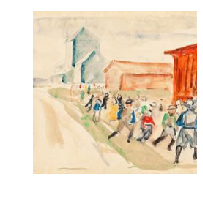

In [21]:
vision.image.show_image(dataset.get(1863))

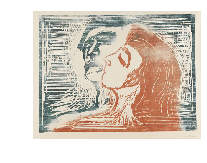

In [22]:
vision.image.show_image(dataset.get(2, with_transformation=False))

In [8]:
list(filter(lambda x: 'mona' in x, dataset.image_paths ))

[]

In [9]:
from PIL import Image
import shutil
for p in dataset.image_paths:
    try:
        Image.open(p)
#         print(p)
    except:
        print('remove '  + p)
        shutil.remove(p)

# 

# Feature Representation Computation
In this part, we will use a pretrained model to compute a dense feature representation of training images. This features will be used in a later process finding similar images. First, we will download the pretrained model (VGG16), then compute the dense features of 4096 (from ReLU-36).

In [437]:
def compute_features_and_save(model, dataset, batch_size=16, test=False, save=False):
    features_list = []
    data_loader = DataLoader(dataset, batch_size=batch_size)
    
    # Compute features for all images
    count = 0
    for batch in tqdm(data_loader):
        if count % 10 == 0:
            print('Batch %d' % count)

        output = model.forward_pass(batch)

        features_list.append(output.detach().numpy())
        if test:
            break
        count = count + 1
        
    features = np.vstack(features_list)
    if save:
        np.save('%s-features' % model.name, features)
    return features

vgg_features = compute_features_and_save(vgg_model, dataset, save=True, test=True)

  0%|          | 0/159 [00:00<?, ?it/s]

Batch 0


In [442]:
class VGGModel:
    def __init__(self, verbose=False):
        self.name = 'vgg-model'
        self.model = tvm.vgg16(pretrained=True)
        if(verbose):
            summary(self.model, (3, 224, 224))
    def forward_pass(self, batch):
        layer_relu_36 = self.model.classifier[:4]

        feature_output = self.model.features.forward(batch)
        feature_output = feature_output.view(feature_output.size(0), -1)

        return layer_relu_36.forward(feature_output)
    
class Resnet152Model:
    def __init__(self, verbose=False):
        self.name = 'resnet152-model'
        self.model = tvm.resnet34(pretrained=True)
        if(verbose):
            summary(self.model, (3, 224, 224))
            
        self.features = nn.Sequential(*list(resnet152_model.model.children())[:-1])


    def forward_pass(self, batch):
        return self.features.forward(batch).view(batch.size(0), -1)
        

In [443]:
resnet152_model = Resnet152Model(verbose=False)
resnet152_features = compute_features_and_save(resnet152_model, dataset, save=True, test=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /Users/heytitle/.torch/models/resnet34-333f7ec4.pth



  0%|          | 0/87306240 [00:00<?, ?it/s]


  1%|          | 499712/87306240 [00:00<00:20, 4164750.57it/s]


  2%|▏         | 1376256/87306240 [00:00<00:17, 4913134.80it/s]


  3%|▎         | 2629632/87306240 [00:00<00:14, 5927850.55it/s]


  4%|▍         | 3637248/87306240 [00:00<00:12, 6753330.23it/s]


  5%|▌         | 4587520/87306240 [00:00<00:11, 7379838.31it/s]


  7%|▋         | 5709824/87306240 [00:00<00:10, 7855486.07it/s]


  8%|▊         | 6897664/87306240 [00:00<00:09, 8701728.36it/s]


  9%|▉         | 8036352/87306240 [00:00<00:08, 9290036.99it/s]


 11%|█         | 9175040/87306240 [00:00<00:07, 9776447.72it/s]


 12%|█▏        | 10338304/87306240 [00:01<00:07, 10254896.53it/s]


 14%|█▎        | 11788288/87306240 [00:01<00:06, 11188508.34it/s]


 15%|█▌        | 13279232/87306240 [00:01<00:06, 12071129.77it/s]


 17%|█▋        | 14770176

Batch 0





  1%|          | 1/159 [00:40<1:47:27, 40.80s/it]

KeyboardInterrupt: 

Batch 0


In [372]:
vgg_model = VGGModel()

In [416]:
resnet152_model.model.avgpool

AvgPool2d(kernel_size=7, stride=1, padding=0)

In [2]:
import numpy as np

In [4]:
img_features = np.load('./sim-results/resnet152-edvard-munch--2018-12-24-23-38-11.npy')
img_features.shape

(2536, 2048)

# Nearest Neighbor Search
In the following, we will use the dense features that we just computed to build an index. This index is constructed specficially by Annoy that provides a quick retrieval of similar images given a query image. 

In [7]:
def construct_ann_index(metric, num_trees, features):
    feature_dims = features[0].shape[0]
    ann = AnnoyIndex(feature_dims, metric=metric)
    for index, feature in enumerate(features):
        ann.add_item(index, feature)

    ann.build(num_trees)
    return ann

ann = construct_ann_index('angular', 50, img_features)

In [8]:
# save for later use
ann.save('resnet_ann')

True

## Load training images' features and the built index to memory

In [9]:
ann = AnnoyIndex(img_features.shape[1], metric='angular')
ann.load('resnet_ann')
ann.get_n_items()

2536

## Exploration!
Now we have all necessary components to start exploring the result. We will first use some training images as query images. Secondly, we will develop a function that fetches an image from a url, and use that image as a query image. 

### Similar images of a training image

In [25]:
def find_similar_images(data_idx, nn=5):
    vision.image.show_image(dataset.get(data_idx))

    axies = plt.subplots(1, nn, figsize=(2*nn,2))[1]
    similar_images = ann.get_nns_by_item(data_idx, nn+1)[1:]
    
    print('Visually similar images` indices : %s' % ','.join(map(str, similar_images)))
    
    for i, tt in enumerate(zip(axies, similar_images)):
        ax, idx = tt
        vision.image.show_image(dataset.get(idx), ax=ax)
    
def find_similar_images_with_name(path):
    idx = None
    for i, t in enumerate(dataset.image_paths):
        if path in t:
            idx = i 
            break
    print('ann idx: %d' % i )
    find_similar_images(idx)

ann idx: 2192
Visually similar images` indices : 1376,1645,202,5,249


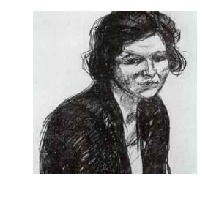

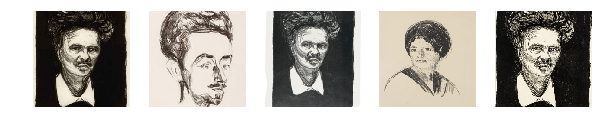

In [26]:
find_similar_images_with_name('765699')

ann idx: 2249
Visually similar images` indices : 274,2153,2155,269,2053


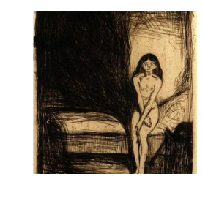

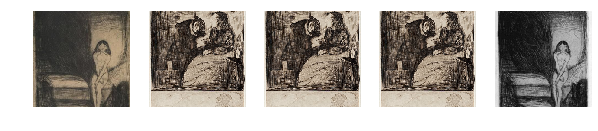

In [27]:
find_similar_images_with_name('798233')

ann idx: 1237
Visually similar images` indices : 614,1616,1578,999,2455


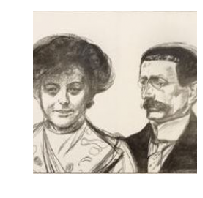

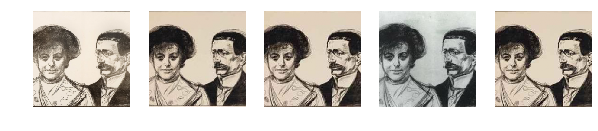

In [29]:
find_similar_images_with_name('3601545')

ann idx: 2319
Visually similar images` indices : 822,913,1805,742,1617
Visually similar images` indices : 822,913,1805,742,1617


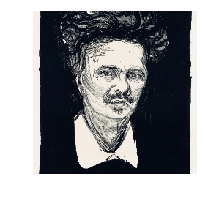

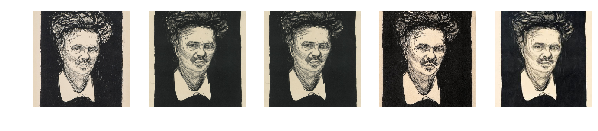

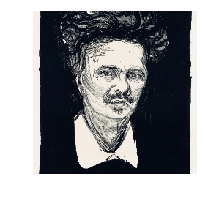

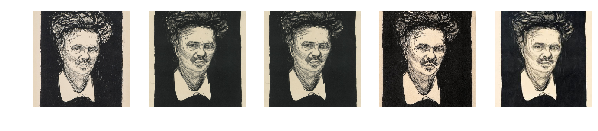

In [344]:
find_similar_images_with_name('8196241')
find_similar_images_with_nn(2319)

ann idx: 140
Visually similar images` indices : 818,523,615,626,2196


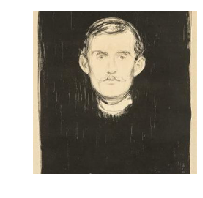

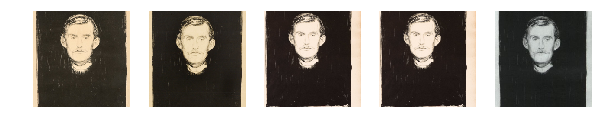

In [30]:
find_similar_images_with_name('11498257')
# find_similar_images_with_nn(140)

In [31]:
find_similar_images_with_name(ann_to_data[5])
# find_similar_images_with_nn(5)

NameError: name 'ann_to_data' is not defined

# Generate results

In [36]:
import pandas as pd
import csv
import json

In [33]:
file = '/Users/heytitle/projects/ac-approximate-nn-search/edvard-munch-lots-with-detail.csv'

lot_dict = dict()

import csv
reader = list(csv.reader(open(file, 'r')))
d = {}
cols = reader[0]
for row in reader[1:]:
    lot = dict(zip(cols, row))
    lot_dict[lot['id']] = lot 

In [34]:
ann_indices = list(range(len(dataset.image_paths)))
data_indices = list(map(lambda x: x.split('/')[-1].split('.')[0], dataset.image_paths))

ann_to_data = dict(zip(ann_indices, data_indices))
data_to_ann = dict(zip(data_indices, ann_indices))

In [39]:
# annoy
arr_results = []
for k in list(data_indices):
#     print(k)
    if k in data_indices:
        ann_idx = data_to_ann[k]
        
        similar_images, distances = ann.get_nns_by_item(ann_idx, 11, include_distances=True)
        similar_images, distances = similar_images[1:], distances[1:]
        try:
            item = dict(
                artwork = dict(lot_dict[k])
            )

            sims = list(map(lambda s: lot_dict[ann_to_data[s]].copy(), similar_images))
            for idx in range(len(sims)):
                sims[idx]['score'] = 1-float(distances[idx])
            item['sims'] = list(sorted(sims, key=lambda x: x['score'], reverse=True))
            arr_results.append(item)
        except:
            print('this one fails %d' % ann_idx)
with open('edvard-much-sims-resnet.json', 'w') as outfile:
    json.dump(arr_results, outfile)

this one fails 136
this one fails 191
this one fails 700
this one fails 810
this one fails 840
this one fails 1014
this one fails 1261
this one fails 1308
this one fails 1329
this one fails 1633
this one fails 2022
this one fails 2281
this one fails 2328
this one fails 2473
this one fails 2535


In [358]:
# exact nn
arr_exact_results = []
for k in list(data_indices):
    data_idx = data_to_ann[k]
    similar_images = np.argsort(sim_mat[data_idx,])[::-1][1:(11)]
    distances = sim_mat[data_idx, similar_images]
    try:
        item = dict(
            artwork = dict(lot_dict[k])
        )

        sims = list(map(lambda s: lot_dict[ann_to_data[s]].copy(), similar_images))
        for idx in range(len(sims)):
            sims[idx]['score'] = float(distances[idx])
        item['sims'] = list(sorted(sims, key=lambda x: x['score'], reverse=True))
        arr_exact_results.append(item)
    except:
        print('this one fails %d' % data_idx)
            
with open('edvard-much-sims-exact-nn.json', 'w') as outfile:
    json.dump(arr_results, outfile)

this one fails 136
this one fails 191
this one fails 810
this one fails 1308
this one fails 1638
this one fails 2022
this one fails 2473
this one fails 2535


In [302]:
ann_to_data[2319]

'8196241'

In [303]:
img_features_mag = np.sqrt(np.sum(np.power(img_features, 2), axis=1))

In [304]:
img_features_normed = img_features / img_features_mag.reshape((-1, 1))

In [305]:
np.sqrt(np.sum(np.power(img_features_normed, 2), axis=1)[:10])

array([0.99999994, 1.        , 1.        , 1.0000001 , 0.99999994,
       1.        , 1.        , 1.        , 1.        , 1.        ],
      dtype=float32)

In [306]:
sim_mat = img_features_normed.dot(img_features_normed.T)

In [307]:
def find_similar_images_with_nn(data_idx, nn=5):
    vision.image._show_image(dataset.get(data_idx))

    axies = plt.subplots(1, nn, figsize=(2*nn,2))[1]
    similar_images = np.argsort(sim_mat[data_idx,])[::-1][1:(nn+1)]
    
    print('Visually similar images` indices : %s' % ','.join(map(str, similar_images)))
    
    for i, tt in enumerate(zip(axies, similar_images)):
        ax, idx = tt
        vision.image._show_image(dataset.get(idx), ax=ax)

Visually similar images` indices : 1737,1428,1253,1930,1332


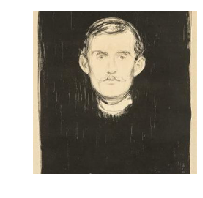

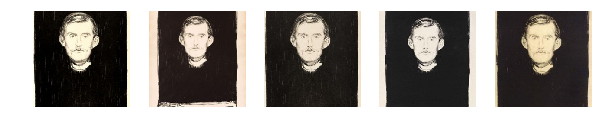

In [338]:
find_similar_images_with_nn(140)

In [356]:
def print_sim_and_score(res, data_idx):
    for s in res[data_idx]['sims'][:10]:
        print('%s | id=%s score %.4f' % (data_to_ann[s['id']], s['id'], s['score']))
print_sim_and_score(arr_results, 5)

2236 | id=7944196 score 0.3325
1935 | id=5288649 score 0.3147
1913 | id=5191151 score 0.3070
2434 | id=9326215 score 0.3057
1652 | id=4712742 score 0.3055
1837 | id=5052909 score 0.3013
547 | id=179294192 score 0.2905
87 | id=102875414 score 0.2892
91 | id=10415938 score 0.2863
2183 | id=75430314 score 0.2808


In [357]:
print_sim_and_score(arr_exact_results, 5)

2236 | id=7944196 score 0.7772
1935 | id=5288649 score 0.7652
1913 | id=5191151 score 0.7599
2434 | id=9326215 score 0.7590
1652 | id=4712742 score 0.7589
1837 | id=5052909 score 0.7559
547 | id=179294192 score 0.7483
87 | id=102875414 score 0.7474
91 | id=10415938 score 0.7453
2183 | id=75430314 score 0.7414
